# Exploring a curated multi-image classification dataset in fastai with augmentations
- Walkthrough of how to train a model that classifies multiple objects in the same image
- This notebook is inspired by this Kaggle kernel: https://www.kaggle.com/jachen36/coco-tiny-test-prediction


In [163]:
# imports for notebook boilerplate
!pip install -Uqq fastbook
import fastbook
import os
from fastbook import *
from fastai.vision.all import *

In [164]:
# set up the notebook for fast.ai
fastbook.setup_book()

In [224]:
# plot_metrics function from https://forums.fast.ai/t/plotting-metrics-after-learning/69937/3 courtesy of Ignacio Oguiza
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

# Ingest the dataset

In [165]:
path = untar_data(URLs.PASCAL_2007)

In [166]:
path.ls()

(#8) [Path('/storage/data/pascal_2007/train'),Path('/storage/data/pascal_2007/test.json'),Path('/storage/data/pascal_2007/segmentation'),Path('/storage/data/pascal_2007/train.json'),Path('/storage/data/pascal_2007/valid.json'),Path('/storage/data/pascal_2007/test.csv'),Path('/storage/data/pascal_2007/train.csv'),Path('/storage/data/pascal_2007/test')]

# Examine the dataset

In [167]:
# bring the structures in the train.json file into Python
with open(path/'train.json') as json_file:
    data = json.load(json_file)
    # each nested structure is a list of dictionaries
    categories = data['categories']
    images = data['images']
    annotations = data['annotations']  
   

In [168]:
print("categories ", categories)
print()
print("subset of images",list(images)[:5])
print()
print("subset of annotations",list(annotations)[:5])

categories  [{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}, {'supercategory': 'none', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'none', 'id': 3, 'name': 'bird'}, {'supercategory': 'none', 'id': 4, 'name': 'boat'}, {'supercategory': 'none', 'id': 5, 'name': 'bottle'}, {'supercategory': 'none', 'id': 6, 'name': 'bus'}, {'supercategory': 'none', 'id': 7, 'name': 'car'}, {'supercategory': 'none', 'id': 8, 'name': 'cat'}, {'supercategory': 'none', 'id': 9, 'name': 'chair'}, {'supercategory': 'none', 'id': 10, 'name': 'cow'}, {'supercategory': 'none', 'id': 11, 'name': 'diningtable'}, {'supercategory': 'none', 'id': 12, 'name': 'dog'}, {'supercategory': 'none', 'id': 13, 'name': 'horse'}, {'supercategory': 'none', 'id': 14, 'name': 'motorbike'}, {'supercategory': 'none', 'id': 15, 'name': 'person'}, {'supercategory': 'none', 'id': 16, 'name': 'pottedplant'}, {'supercategory': 'none', 'id': 17, 'name': 'sheep'}, {'supercategory': 'none', 'id': 18, 'name': 'sofa'}, {'supercatego

In [169]:
# define a Python dictionary for the contents of the train.json file
image_files, bbox_lbl = get_annotations(path/'train.json')
img_bbox_combo = dict(zip(image_files, bbox_lbl))

In [170]:
bbox_lbl[0:4]

[([[155, 96, 351, 270]], ['car']),
 ([[184, 61, 279, 199], [89, 77, 403, 336]], ['person', 'horse']),
 ([[8, 229, 245, 500],
   [229, 219, 334, 500],
   [1, 177, 90, 500],
   [1, 0, 117, 369],
   [2, 1, 243, 462],
   [224, 0, 334, 486]],
  ['bicycle', 'bicycle', 'bicycle', 'person', 'person', 'person']),
 ([[89, 124, 337, 212]], ['car'])]

In [171]:
# examine the bounding box and labels for one of the image files
img_bbox_combo[image_files[1]][1]

['person', 'horse']

In [172]:
# get the label for one of bounding boxes for one of the image files
img_bbox_combo[image_files[5]][1][0]

'aeroplane'

In [173]:
image_files[5]

'000033.jpg'

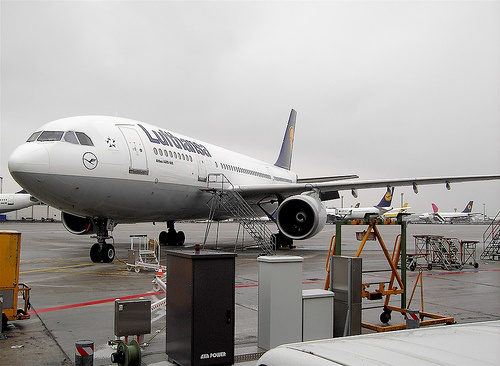

In [174]:
# look at one of the images
image_subpath = 'train/'+image_files[5]
img = PILImage.create(path/image_subpath)
img

# Prepare the data and define the dataloaders object

In [175]:
# function to return the value corresponding with a key in a list of dictionaries
def get_category(in_key_value,in_key,out_key,dict_list):
    return([cat[out_key] for cat in dict_list if cat[in_key]==in_key_value] )

In [176]:
# exercise os.path.basename
os.path.basename('/storage/data/pascal_2007/train/006635.jpg')

'006635.jpg'

In [177]:
def label_func(x): return get_category(get_category(os.path.basename(x),'file_name','id',images)[0],'image_id','bbox',annotations)

In [178]:
# return the bounding box for a given filename
def get_bbox(filename):
    return np.array(img_bbox_combo[os.path.basename(filename)][0])

In [179]:
# return the label (category) for a given filename
def get_lbl(filename):
    return np.array(img_bbox_combo[os.path.basename(filename)][1],dtype=object)

In [180]:
get_lbl('/storage/data/pascal_2007/train/006635.jpg')

array(['train'], dtype=object)

In [181]:
#get_lbl('/storage/data/pascal_2007/train/003772.jpg')

In [182]:
get_lbl('/storage/data/pascal_2007/train/007911.jpg')


array(['motorbike', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person'], dtype=object)

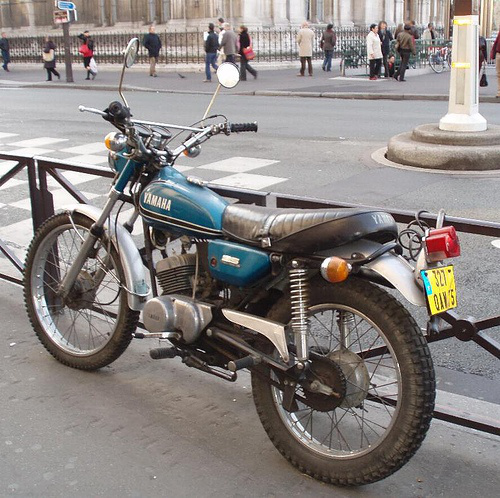

In [183]:
image_subpath = 'train/007911.jpg'
img = PILImage.create(path/image_subpath)
img

In [184]:
# get the image ID for a given image file from the training set
file_path = Path('/storage/data/pascal_2007/train/008513.jpg')
get_category(os.path.basename(file_path),'file_name','id',images)


[]

In [185]:
# print the size of the training and test sets
print("number of training images: ",len(get_image_files(path/'train')))
print("number of testing images: ",len(get_image_files(path/'test')))

number of training images:  5011
number of testing images:  4952


In [186]:
# print the number of categories in the annotations
print("number of categories is: ",len(categories))

number of categories is:  20


In [187]:
# get a set of image file names from the training set
get_image_files(path/'train')[0:5]

(#5) [Path('/storage/data/pascal_2007/train/003772.jpg'),Path('/storage/data/pascal_2007/train/006066.jpg'),Path('/storage/data/pascal_2007/train/003767.jpg'),Path('/storage/data/pascal_2007/train/006547.jpg'),Path('/storage/data/pascal_2007/train/008444.jpg')]

In [188]:
# exercise the get_lbl function for a given image file from the training set
get_lbl(Path('/storage/data/pascal_2007/train/006547.jpg'))

array(['cat'], dtype=object)

In [189]:
# get the image ID for a given image file from the training set
get_category(os.path.basename(Path('/storage/data/pascal_2007/train/003772.jpg')),'file_name','id',images)

[]

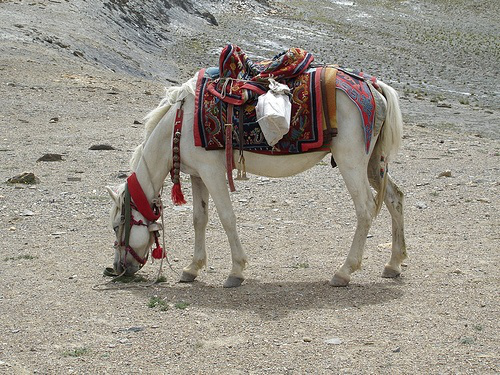

In [190]:
# view the image
image_subpath = 'train/003772.jpg'
img = PILImage.create(path/image_subpath)
img

In [191]:
# define a function to return the set of image files with valid annotations
def get_items(noop):
    return_list = []
    empty_list = []
    # filter the training files and keep only the ones with valid info in the JSON file
    for file_path in get_image_files(path/'train'):
        file_id_list = get_category(os.path.basename(file_path),'file_name','id',images)
        if len(file_id_list) > 0:
            return_list.append(file_path)
        else:
            empty_list.append(file_path)
    print("len(return_list): ",len(return_list))
    print("len(empty_list): ",len(empty_list))
    return(return_list)
        
        

In [192]:
return_list = get_items("junk")

len(return_list):  2501
len(empty_list):  2510


In [193]:
# define a DataBlock object using the get_items and get_lbl functions
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                 get_items = get_items, 
                 splitter=RandomSplitter(),
                 get_y=[get_lbl],
                 item_tfms = RandomResizedCrop(168, min_scale=0.7),
                 n_inp=1)
#                  batch_tfms=aug_transforms(mult=4),

In [194]:
# define a dataloders object using the DataBlock object
dls = db.dataloaders(path,bs=32)

len(return_list):  2501
len(empty_list):  2510


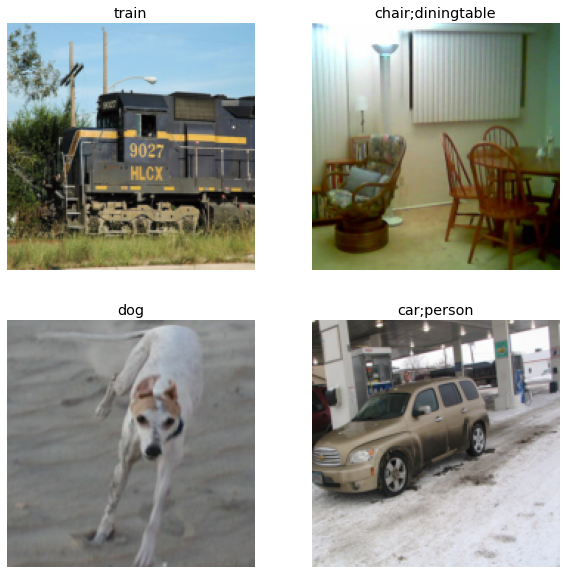

In [195]:
# display a batch 
dls.show_batch(max_n=4, figsize=(10,10))

In [196]:
print("categories ", categories)

categories  [{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}, {'supercategory': 'none', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'none', 'id': 3, 'name': 'bird'}, {'supercategory': 'none', 'id': 4, 'name': 'boat'}, {'supercategory': 'none', 'id': 5, 'name': 'bottle'}, {'supercategory': 'none', 'id': 6, 'name': 'bus'}, {'supercategory': 'none', 'id': 7, 'name': 'car'}, {'supercategory': 'none', 'id': 8, 'name': 'cat'}, {'supercategory': 'none', 'id': 9, 'name': 'chair'}, {'supercategory': 'none', 'id': 10, 'name': 'cow'}, {'supercategory': 'none', 'id': 11, 'name': 'diningtable'}, {'supercategory': 'none', 'id': 12, 'name': 'dog'}, {'supercategory': 'none', 'id': 13, 'name': 'horse'}, {'supercategory': 'none', 'id': 14, 'name': 'motorbike'}, {'supercategory': 'none', 'id': 15, 'name': 'person'}, {'supercategory': 'none', 'id': 16, 'name': 'pottedplant'}, {'supercategory': 'none', 'id': 17, 'name': 'sheep'}, {'supercategory': 'none', 'id': 18, 'name': 'sofa'}, {'supercatego

In [197]:
print("subset of annotations",list(annotations)[:5])

subset of annotations [{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'iscrowd': 0, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'category_id': 7, 'id': 1, 'ignore': 0}, {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]], 'area': 13110, 'iscrowd': 0, 'image_id': 17, 'bbox': [184, 61, 95, 138], 'category_id': 15, 'id': 2, 'ignore': 0}, {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]], 'area': 81326, 'iscrowd': 0, 'image_id': 17, 'bbox': [89, 77, 314, 259], 'category_id': 13, 'id': 3, 'ignore': 0}, {'segmentation': [[8, 229, 8, 500, 245, 500, 245, 229]], 'area': 64227, 'iscrowd': 0, 'image_id': 23, 'bbox': [8, 229, 237, 271], 'category_id': 2, 'id': 4, 'ignore': 0}, {'segmentation': [[229, 219, 229, 500, 334, 500, 334, 219]], 'area': 29505, 'iscrowd': 0, 'image_id': 23, 'bbox': [229, 219, 105, 281], 'category_id': 2, 'id': 5, 'ignore': 0}]


# Define and train the model

In [221]:
# define the model
learn = cnn_learner(dls, resnet18,metrics=accuracy_multi)

 

In [222]:
%%time
# fine tune the pre-trained model
learn.fine_tune(10)

CPU times: user 1min 17s, sys: 18.2 s, total: 1min 35s
Wall time: 1min 47s


# Exercise the model

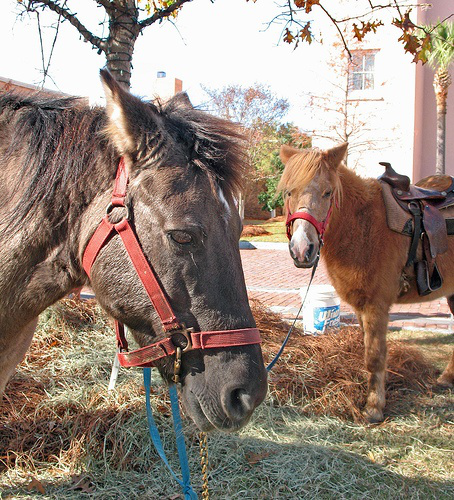

In [200]:
# display an image from the test set
img_test_files = get_image_files(path/"test")
img2 = PILImage.create(img_test_files[100])
img2

In [201]:
# exercise the trained model on this image
learn.predict(img2)

((#2) ['horse','person'],
 TensorImage([False, False, False, False, False, False, False, False, False, False, False, False,  True, False,  True, False, False, False, False, False]),
 TensorImage([0.0027, 0.0095, 0.0013, 0.0062, 0.0029, 0.0025, 0.0387, 0.0119, 0.0020, 0.0361, 0.0017, 0.0634, 0.8839, 0.0066, 0.5237, 0.0025, 0.0045, 0.0069, 0.0048, 0.0032]))

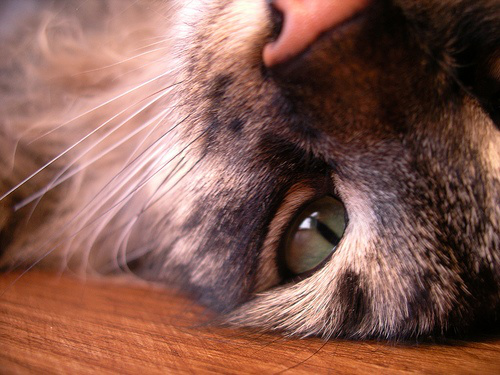

In [202]:
# display another image from the test set
img3 = PILImage.create(img_test_files[200])
img3

In [203]:
# exercise the trained model on this image
learn.predict(img3)

((#1) ['cat'],
 TensorImage([False, False, False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, False, False, False]),
 TensorImage([6.1204e-04, 1.0932e-03, 4.4085e-03, 6.5840e-03, 4.1509e-03, 5.9352e-04, 1.7513e-03, 9.8673e-01, 5.1744e-04, 3.8044e-02, 1.3542e-03, 5.9213e-04, 3.7041e-02, 1.1067e-03, 7.7902e-03, 3.0771e-04,
         6.7791e-03, 1.1720e-03, 2.3433e-03, 9.2608e-03]))

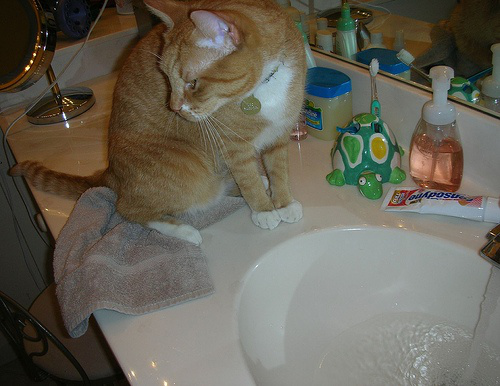

In [204]:
# display another image from the test set
img4 = PILImage.create(img_test_files[120])
img4

In [205]:
# exercise the trained model on this image
learn.predict(img4)

((#2) ['cat','person'],
 TensorImage([False, False, False, False, False, False, False,  True, False, False, False, False, False, False,  True, False, False, False, False, False]),
 TensorImage([2.4419e-03, 1.2791e-02, 7.3230e-04, 3.1019e-03, 1.3714e-01, 5.2454e-03, 8.7088e-03, 7.0314e-01, 8.4748e-02, 7.7238e-03, 3.0055e-02, 3.3661e-02, 2.3376e-03, 8.0472e-03, 5.9366e-01, 4.1176e-02,
         5.3533e-03, 9.2669e-02, 5.9839e-04, 1.0941e-02]))

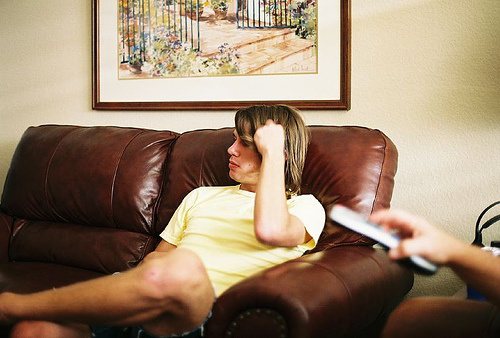

In [206]:
# display another image from the test set
img5 = PILImage.create(img_test_files[150])
img5

In [207]:
# exercise the trained model on this image
learn.predict(img5)

((#1) ['person'],
 TensorImage([False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True, False, False, False, False, False]),
 TensorImage([9.4125e-04, 9.9579e-04, 2.4493e-03, 8.8553e-04, 1.5762e-01, 6.7473e-04, 6.6259e-04, 3.2629e-02, 1.9100e-01, 1.2410e-03, 3.8910e-02, 3.1958e-02, 3.4683e-02, 3.1988e-04, 9.9765e-01, 1.4463e-02,
         2.1230e-03, 3.0949e-01, 5.0139e-04, 2.7866e-03]))

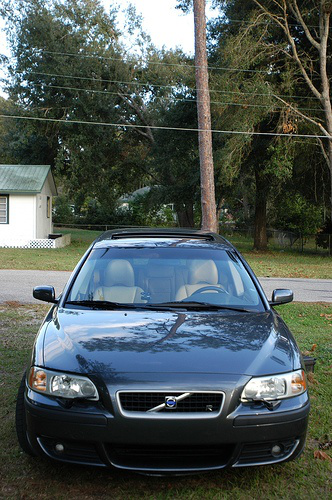

In [208]:
# display another image from the test set
img6 = PILImage.create(img_test_files[900])
img6

In [209]:
# exercise the trained model on this image
learn.predict(img6)

((#1) ['car'],
 TensorImage([False, False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, False, False, False, False]),
 TensorImage([1.0776e-03, 4.1995e-03, 3.3826e-03, 8.7485e-03, 1.5848e-03, 1.5541e-03, 9.8606e-01, 1.0056e-03, 8.8376e-04, 9.9770e-04, 8.8997e-04, 1.2113e-03, 7.4349e-04, 4.6830e-03, 1.3922e-01, 1.3605e-03,
         2.5154e-03, 8.5436e-04, 2.0533e-03, 1.0648e-03]))

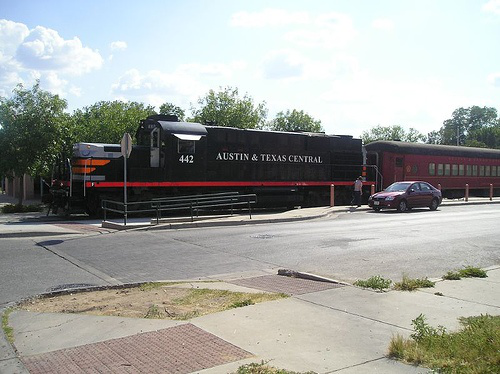

In [210]:
# display another image from the test set
img7 = PILImage.create(img_test_files[950])
img7

In [211]:
# exercise the trained model on this image
learn.predict(img7)

((#1) ['train'],
 TensorImage([False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True, False]),
 TensorImage([1.2432e-02, 3.2741e-03, 5.2905e-04, 1.0783e-03, 1.0302e-03, 1.3564e-01, 5.6326e-02, 1.0895e-03, 4.7682e-03, 2.9061e-03, 4.4166e-04, 1.0555e-03, 4.0727e-04, 3.2110e-03, 1.8528e-02, 1.0510e-03,
         2.2167e-03, 2.3303e-03, 9.7280e-01, 2.5951e-03]))

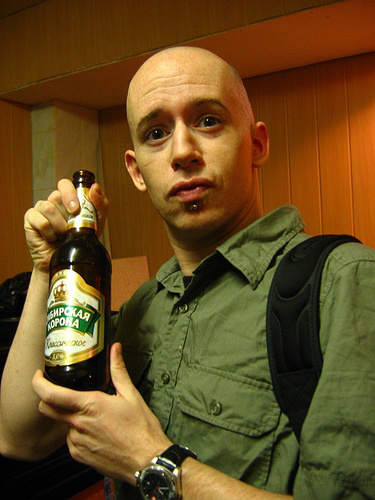

In [217]:
# display another image from the test set
img8 = PILImage.create(img_test_files[800])
img8

In [218]:
learn.predict(img8)

((#2) ['bottle','person'],
 TensorImage([False, False, False, False,  True, False, False, False, False, False, False, False, False, False,  True, False, False, False, False, False]),
 TensorImage([2.0719e-04, 2.2223e-03, 1.3971e-03, 9.9636e-04, 5.2126e-01, 1.1950e-03, 4.5739e-04, 1.3319e-03, 3.0496e-03, 3.0268e-04, 1.6554e-03, 2.5726e-03, 4.8491e-04, 1.0505e-03, 9.9776e-01, 5.4674e-03,
         2.7575e-03, 3.6426e-03, 9.5740e-04, 5.3455e-03]))

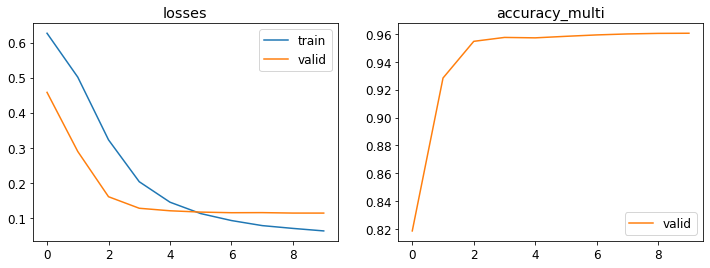

In [225]:
learn.recorder.plot_metrics()

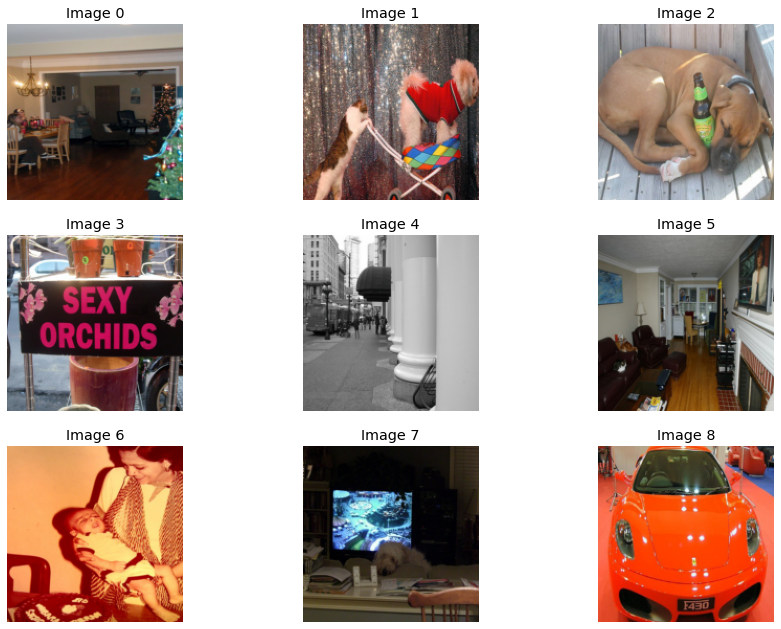

In [229]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

# Get accuracy for the test set

In [ ]:
# set the path to a writeable directory and save the model
learn.path = Path('/notebooks/temp/models')
learn.export('multi_image_jun5_2021.pkl')

In [ ]:
# load the saved model to a new learner object
learn2 = load_learner('/notebooks/temp/models/multi_image_jun5_2021.pkl')

In [ ]:
# define a function to return the set of image files with valid annotations from the test set
def get_items_test(noop):
    return_list = []
    empty_list = []
    # filter the training files and keep only the ones with valid info in the JSON file
    for file_path in get_image_files(path/'test'):
        file_id_list = get_category(os.path.basename(file_path),'file_name','id',images)
        if len(file_id_list) > 0:
            return_list.append(file_path)
        else:
            empty_list.append(file_path)
    return(return_list)

# Examine details of the test set

In [212]:
# get the path for a test set file by index
img_test_files[950]

Path('/storage/data/pascal_2007/test/001935.jpg')

In [213]:
# load the test annotations into Python structures
with open(path/'test.json') as json_file:
    data_test = json.load(json_file)
    # each nested structure is a list of dictionaries
    categories_test = data_test['categories']
    images_test = data_test['images']
    annotations_test = data_test['annotations'] 

In [214]:
# get the annotations for a particular file in the test set
get_category('001935.jpg','file_name','id',images_test)

[1935]

In [215]:
# get the categories of objects identified in image 1935
get_category(1935,'image_id','category_id',annotations_test)

[19, 7, 15]

In [216]:
annotations_test[0:4]

[{'segmentation': [[47, 239, 47, 371, 195, 371, 195, 239]],
  'area': 19536,
  'iscrowd': 0,
  'image_id': 1,
  'bbox': [47, 239, 148, 132],
  'category_id': 12,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[7, 11, 7, 498, 352, 498, 352, 11]],
  'area': 168015,
  'iscrowd': 0,
  'image_id': 1,
  'bbox': [7, 11, 345, 487],
  'category_id': 15,
  'id': 2,
  'ignore': 0},
 {'segmentation': [[138, 199, 138, 301, 207, 301, 207, 199]],
  'area': 7038,
  'iscrowd': 0,
  'image_id': 2,
  'bbox': [138, 199, 69, 102],
  'category_id': 19,
  'id': 3,
  'ignore': 0},
 {'segmentation': [[122, 154, 122, 195, 215, 195, 215, 154]],
  'area': 3813,
  'iscrowd': 0,
  'image_id': 3,
  'bbox': [122, 154, 93, 41],
  'category_id': 18,
  'id': 4,
  'ignore': 0}]